In [1]:
from flask import Flask, jsonify, Response, request, after_this_request
import mysql.connector
import pandas as pd
import json
import joblib
from sklearn.tree import _tree
import numpy as np
from keras.models import load_model
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from keras.models import load_model
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow as tf
import keras
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure
import seaborn as sns 
from io import BytesIO
import matplotlib.pyplot as plt
from flask import send_file
from datetime import datetime

Using TensorFlow backend.
/opt/anaconda3/envs/tese/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/envs/tese/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/envs/tese/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/envs/tese/lib/python3.7/site-packag

In [2]:
app = Flask(__name__)

@app.route('/')
def hello_world():
    return 'HELLO DANI'

In [3]:
mydb = mysql.connector.connect(
  host="freedb.tech",
  port=3306,
  user="freedbtech_etardata",
  passwd="etardata2021",
  database="freedbtech_etardatadb"
)

cursor = mydb.cursor()

query_indicator_electricidade = "SELECT indicator_table.indicator_name, indicator_table.indicator_type, indicator_table.units, indicator_value_table.sub_type, indicator_value_table.input, indicator_value_table.value, indicator_value_table.date, indicator_value_table.city_name FROM indicator_table INNER JOIN indicator_value_table ON indicator_table.id = indicator_value_table.indicator"
cursor.execute(query_indicator_electricidade)
result_indicator_electricidade = cursor.fetchall()

data = pd.DataFrame((result_indicator_electricidade),columns=['indicator_name','indicator_type','units','sub_type','input','value','date','city_name'])
data = data[data.indicator_type == 'Controlo Analitico']
data = data.loc[((data.sub_type == 'Afluente Bruto') | (data.sub_type == 'Efluente Tratado'))]
data.date = pd.to_datetime(data.date).dt.date
data.date = pd.to_datetime(data.date)
display(data)

,indicator_name,indicator_type,units,sub_type,input,value,date,city_name
24037,azoto_total,Controlo Analitico,mg/l,Afluente Bruto,Entrada,68.000,2018-08-01,Vila Real
24038,azoto_total,Controlo Analitico,mg/l,Afluente Bruto,Entrada,76.000,2018-08-08,Vila Real
24039,azoto_total,Controlo Analitico,mg/l,Afluente Bruto,Entrada,72.000,2018-08-15,Vila Real
24040,azoto_total,Controlo Analitico,mg/l,Afluente Bruto,Entrada,63.000,2018-08-22,Vila Real
24041,azoto_total,Controlo Analitico,mg/l,Afluente Bruto,Entrada,77.000,2018-08-29,Vila Real
...,...,...,...,...,...,...,...,...
30056,ortofosfatos,Controlo Analitico,mg/l,Efluente Tratado,Saida,4.470,2020-04-27,Vila Real
30057,ortofosfatos,Controlo Analitico,mg/l,Efluente Tratado,Saida,1.320,2020-05-04,Vila Real
30058,ortofosfatos,Controlo Analitico,mg/l,Efluente Tratado,Saida,2.270,2020-05-11,Vila Real
30059,ortofosfatos,Controlo Analitico,mg/l,Efluente Tratado,Saida,0.958,2020-05-18,Vila Real


In [4]:
bins = [0, 91, 183, 275, 366]
labels=['Inverno', 'Primavera', 'Verão', 'Outono']

for i in data.indicator_name.unique():
    dados_x = data[data.indicator_name == i]
    for p, o in dados_x.groupby("sub_type"):
        o.date = pd.to_datetime(o.date).dt.date
        o.date = pd.to_datetime(o.date)
        o = o.groupby('sub_type').resample('7D', on='date').mean().reset_index().sort_values(by='date')
        datas_falta = pd.date_range(start = o.date.min(), end = o.date.max(), freq="7D").difference(o.date)
        datas_em_falta = dados_x.reindex(datas_falta, fill_value = 0).reset_index()
        datas_em_falta.drop(columns=['date'], inplace = True)
        datas_em_falta.rename(columns={'index': 'date'}, inplace = True)
        for o, p in datas_em_falta.iterrows():
            data = data.append({ 'indicator_name': i, 'sub_type': p, 'date':p.date, 'value':p.value}, ignore_index=True)
datasets = []
for x in data.indicator_name.unique():
    d = data[data.indicator_name == x]
    for i in d.sub_type.unique():
        dados_x = d[d.sub_type == i].copy()
        dados_x.date = pd.to_datetime(dados_x.date).dt.date
        dados_x.date = pd.to_datetime(dados_x.date)

        dados_x.date = dados_x.date.dt.to_period('W').apply(lambda r: r.start_time)
        dados_x = dados_x.groupby([dados_x['date'],dados_x['indicator_name'],dados_x['sub_type'], dados_x['units']]).aggregate('mean').reset_index()
        #dados_x = dados_x.groupby(['indicator_name','sub_type','units']).resample('', on='date').mean().reset_index().sort_values(by='date')

        dados_x = dados_x.loc[dados_x.notnull().all(axis=1).cummax()]
        nan = dados_x[dados_x.isnull().any(1)]
        if len(nan) > 0:
            idx = dados_x.loc[dados_x.date == nan.date.iloc[0]]
            num_timesteps = 3
            while (len(dados_x.loc[:idx.index[0]]) - 1) < num_timesteps:
                dados_x.at[idx.index[0],'value'] = dados_x.loc[:idx.index[0]].mean()
                nan = dados_x[dados_x.isnull().any(1)]
                if len(nan) == 0:
                    break
                else:
                    idx = dados_x.loc[dados_x.date == nan.date.iloc[0]]
            while int(dados_x.value.isnull().sum()) > 0:
                dados_x.value = dados_x.value.fillna(dados_x.value.rolling(num_timesteps).mean().shift())
        datasets.append(dados_x)
dados_final = pd.concat(datasets)

dados_con_analitico = dados_final.copy()
for i,p in dados_con_analitico.iterrows():
    dados_con_analitico.loc[i, [p.indicator_name + " em " + p.sub_type]] = np.nan
    dados_con_analitico.loc[i, [p.indicator_name + " em " + p.sub_type]] = p.value
dados_con_analitico = dados_con_analitico.drop(columns=['value'])
dados_con_analitico = dados_con_analitico.groupby('date').aggregate('mean').reset_index()
for x in dados_con_analitico.columns:
    dados_x = dados_con_analitico[x]
    if dados_x.isnull().sum() > 0:
        while int(dados_x.isnull().sum()) > 0:
                dados_x = dados_x.fillna(dados_x.rolling(3).mean().shift())
        dados_con_analitico[x] = dados_x
doy = dados_con_analitico.date.dt.dayofyear
dados_con_analitico['estacao_ano'] = pd.cut(doy + 11 - 366*(doy > 355), bins=bins, labels=labels)
dados_con_analitico['estacao_ano_numeric'] = dados_con_analitico.estacao_ano.cat.codes
dados_forecast = dados_con_analitico[['date','azoto_total em Efluente Tratado','azoto_total em Afluente Bruto','cqo em Efluente Tratado','sst em Afluente Bruto','amonia em Efluente Tratado','ortofosfatos em Efluente Tratado']]

In [5]:
'''def data_treatment():
    
    mydb = mysql.connector.connect(
      host="freedb.tech",
      port=3306,
      user="freedbtech_etardata",
      passwd="etardata2021",
      database="freedbtech_etardatadb"
    )

    cursor = mydb.cursor()

    query_indicator_electricidade = "SELECT indicator_table.indicator_name, indicator_table.indicator_type, indicator_table.units, indicator_value_table.sub_type, indicator_value_table.input, indicator_value_table.value, indicator_value_table.date, indicator_value_table.city_name FROM indicator_table INNER JOIN indicator_value_table ON indicator_table.id = indicator_value_table.indicator"
    cursor.execute(query_indicator_electricidade)
    result_indicator_electricidade = cursor.fetchall()

    data = pd.DataFrame((result_indicator_electricidade),columns=['indicator_name','indicator_type','units','sub_type','input','value','date','city_name'])
    data = data[data.indicator_type == 'Controlo Analitico']
    data = data.loc[((data.sub_type == 'Afluente Bruto') | (data.sub_type == 'Efluente Tratado'))]
    data.date = pd.to_datetime(data.date).dt.date
    data.date = pd.to_datetime(data.date)
    
    bins = [0, 91, 183, 275, 366]
    labels=['Inverno', 'Primavera', 'Verão', 'Outono']
    
    for i in data.indicator_name.unique():
        dados_x = data[data.indicator_name == i]
        for p, o in dados_x.groupby("sub_type"):
            o.date = pd.to_datetime(o.date).dt.date
            o.date = pd.to_datetime(o.date)
            o = o.groupby('sub_type').resample('7D', on='date').mean().reset_index().sort_values(by='date')
            datas_falta = pd.date_range(start = o.date.min(), end = o.date.max(), freq="7D").difference(o.date)
            datas_em_falta = dados_x.reindex(datas_falta, fill_value = 0).reset_index()
            datas_em_falta.drop(columns=['date'], inplace = True)
            datas_em_falta.rename(columns={'index': 'date'}, inplace = True)
            for o, p in datas_em_falta.iterrows():
                data = data.append({ 'indicator_name': i, 'sub_type': p, 'date':p.date, 'value':p.value}, ignore_index=True)
    datasets = []
    for x in data.indicator_name.unique():
        d = data[data.indicator_name == x]
        for i in d.sub_type.unique():
            dados_x = d[d.sub_type == i].copy()
            dados_x.date = pd.to_datetime(dados_x.date).dt.date
            dados_x.date = pd.to_datetime(dados_x.date)

            dados_x.date = dados_x.date.dt.to_period('W').apply(lambda r: r.start_time)
            dados_x = dados_x.groupby([dados_x['date'],dados_x['indicator_name'],dados_x['sub_type'], dados_x['units']]).aggregate('mean').reset_index()
            #dados_x = dados_x.groupby(['indicator_name','sub_type','units']).resample('', on='date').mean().reset_index().sort_values(by='date')

            dados_x = dados_x.loc[dados_x.notnull().all(axis=1).cummax()]
            nan = dados_x[dados_x.isnull().any(1)]
            if len(nan) > 0:
                idx = dados_x.loc[dados_x.date == nan.date.iloc[0]]
                num_timesteps = 3
                while (len(dados_x.loc[:idx.index[0]]) - 1) < num_timesteps:
                    dados_x.at[idx.index[0],'value'] = dados_x.loc[:idx.index[0]].mean()
                    nan = dados_x[dados_x.isnull().any(1)]
                    if len(nan) == 0:
                        break
                    else:
                        idx = dados_x.loc[dados_x.date == nan.date.iloc[0]]
                while int(dados_x.value.isnull().sum()) > 0:
                    dados_x.value = dados_x.value.fillna(dados_x.value.rolling(num_timesteps).mean().shift())
            datasets.append(dados_x)
    dados_final = pd.concat(datasets)

    dados_con_analitico = dados_final.copy()
    for i,p in dados_con_analitico.iterrows():
        dados_con_analitico.loc[i, [p.indicator_name + " em " + p.sub_type]] = np.nan
        dados_con_analitico.loc[i, [p.indicator_name + " em " + p.sub_type]] = p.value
    dados_con_analitico = dados_con_analitico.drop(columns=['value'])
    dados_con_analitico = dados_con_analitico.groupby('date').aggregate('mean').reset_index()
    for x in dados_con_analitico.columns:
        dados_x = dados_con_analitico[x]
        if dados_x.isnull().sum() > 0:
            while int(dados_x.isnull().sum()) > 0:
                    dados_x = dados_x.fillna(dados_x.rolling(3).mean().shift())
            dados_con_analitico[x] = dados_x
    doy = dados_con_analitico.date.dt.dayofyear
    dados_con_analitico['estacao_ano'] = pd.cut(doy + 11 - 366*(doy > 355), bins=bins, labels=labels)
    dados_con_analitico['estacao_ano_numeric'] = dados_con_analitico.estacao_ano.cat.codes
    dados_for_forecast = dados_con_analitico[['date','azoto_total em Efluente Tratado','azoto_total em Afluente Bruto','cqo em Efluente Tratado','sst em Afluente Bruto','amonia em Efluente Tratado','ortofosfatos em Efluente Tratado']]
    
    return dados_for_forecast'''

'def data_treatment():\n    \n    mydb = mysql.connector.connect(\n      host="freedb.tech",\n      port=3306,\n      user="freedbtech_etardata",\n      passwd="etardata2021",\n      database="freedbtech_etardatadb"\n    )\n\n    cursor = mydb.cursor()\n\n    query_indicator_electricidade = "SELECT indicator_table.indicator_name, indicator_table.indicator_type, indicator_table.units, indicator_value_table.sub_type, indicator_value_table.input, indicator_value_table.value, indicator_value_table.date, indicator_value_table.city_name FROM indicator_table INNER JOIN indicator_value_table ON indicator_table.id = indicator_value_table.indicator"\n    cursor.execute(query_indicator_electricidade)\n    result_indicator_electricidade = cursor.fetchall()\n\n    data = pd.DataFrame((result_indicator_electricidade),columns=[\'indicator_name\',\'indicator_type\',\'units\',\'sub_type\',\'input\',\'value\',\'date\',\'city_name\'])\n    data = data[data.indicator_type == \'Controlo Analitico\']\n    d

In [6]:
def series_to_supervised(data, timesteps, multisteps, dropnan=False, fill_value=0):
    data = pd.DataFrame(data)
    new = pd.DataFrame()
    for i in range(timesteps, 0, -1):
        if fill_value:
            new = pd.concat([new, data.shift(i, fill_value=fill_value)], axis=1)
        else:
            new = pd.concat([new, data.shift(i)], axis=1)

    for j in range(0, multisteps):
        if fill_value:
            new = pd.concat([new, data.iloc[:,0].shift(-j, fill_value=fill_value)],axis=1)
        else:
            new = pd.concat([new, data.iloc[:,0].shift(-j)],axis=1)
    if dropnan:
        new.dropna(inplace=True)
    return new.values

In [7]:
@app.route('/dados')
def dados():
    @after_this_request
    def add_header(response):
        response.headers['Access-Control-Allow-Origin'] = '*'
        return response
    #result = data.to_json(orient="records")
    return Response(data.to_json(orient="records"), mimetype='application/json')#jsonify(result)

In [8]:
@app.route('/last_date')
def last_date():
    @after_this_request
    def add_header(response):
        response.headers['Access-Control-Allow-Origin'] = '*'
        return response
    last_date = dados_forecast.date.iloc[-1]
    res = last_date.strftime("%d/%m/%Y")
    return jsonify(res)

In [9]:
@app.route('/prediction', methods=['GET','POST'])
def prediction():
    @after_this_request
    def add_header(response):
        response.headers['Access-Control-Allow-Origin'] = '*'
        return response
    if request.method == 'POST':
        #result_post = request.form
        pred = [[request.form['azoto_total_em_Afluente_Bruto'], request.form['cqo_em_Efluente_Tratado'], request.form['sst_em_Afluente_Bruto'], request.form['amonia_em_Efluente_Tratado'],	request.form['ortofosfatos_em_Efluente_Tratado']]]
    loaded_model = joblib.load('dt_model.sav')
    prediction = loaded_model.predict(pred)
    result = {'azoto_total_em_Afluente_Bruto':request.form['azoto_total_em_Afluente_Bruto'], 'cqo_em_Efluente_Tratado': request.form['cqo_em_Efluente_Tratado'], 'sst_em_Afluente_Bruto':request.form['sst_em_Afluente_Bruto'], 'amonia_em_Efluente_Tratado': request.form['amonia_em_Efluente_Tratado'], 'ortofosfatos_em_Efluente_Tratado': request.form['ortofosfatos_em_Efluente_Tratado'], 'previsao': str(prediction[0])}
    return result

In [10]:
def get_rules(tree, feature_names, class_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    paths = []
    path = []
    
    def recurse(node, path, paths):
        
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            p1, p2 = list(path), list(path)
            p1 += [f"({name} <= {np.round(threshold, 3)})"]
            recurse(tree_.children_left[node], p1, paths)
            p2 += [f"({name} > {np.round(threshold, 3)})"]
            recurse(tree_.children_right[node], p2, paths)
        else:
            path += [(tree_.value[node], tree_.n_node_samples[node])]
            paths += [path]
            
    recurse(0, path, paths)

    # sort by samples count
    samples_count = [p[-1][1] for p in paths]
    ii = list(np.argsort(samples_count))
    paths = [paths[i] for i in reversed(ii)]
    
    rules = []
    for path in paths:
        rule = "Se "
        
        for p in path[:-1]:
            if rule != "Se ":
                rule += " e "
            rule += str(p)
        rule += " então "
        if class_names is None:
            rule += "o valor é: "+str(np.round(path[-1][0][0][0],3))
        else:
            classes = path[-1][0][0]
            l = np.argmax(classes)
            rule += f"class: {class_names[l]} (proba: {np.round(100.0*classes[l]/np.sum(classes),2)}%)"
        #rule += f" | based on {path[-1][1]:,} samples"
        rules += [rule]
        
    return rules

In [11]:
@app.route('/rules')
def rules():
    rules_array=[]
    @after_this_request
    def add_header(response):
        response.headers['Access-Control-Allow-Origin'] = '*'
        return response
    #result_post = request.form
    loaded_model = joblib.load('dt_model.sav')
    dataframe_for_columns_name = pd.DataFrame({'Azoto total em Afluente Bruto': 111, 'CQO em Efluente Tratado': 111, 'SST em Afluente Bruto': 111, 'Amonia em Efluente Tratado': 111, 'Ostofosfatos em Efluente Tratado': 111}, index=[0])
    rules = get_rules(loaded_model, dataframe_for_columns_name.columns, None)
    for r in rules:
        rules_array.append(r)
    return jsonify(rules_array)

In [12]:
@app.route('/prediction_next_days',  methods=['GET','POST'])
def predict_future():
    @after_this_request
    def add_header(response):
        response.headers['Access-Control-Allow-Origin'] = '*'
        return response 
    if request.method == 'POST':
        #result_post = request.form
        pred_weeks = [[request.form['weeks_pred']]]

        scaler = MinMaxScaler(feature_range=(-1,1))
        model = tf.keras.models.load_model('lstm_model.h5')
        #dados_forecast = data_treatment()
        #dados_super = series_to_supervised(dados_forecast.loc[:,dados_forecast.columns != 'date'], 7, 1, dropnan = True)
        '''tscv = TimeSeriesSplit(n_splits = 2)
        scaler = MinMaxScaler(feature_range=(-1,1))

        for i, (train_index, test_index) in enumerate(tscv.split(dados_super)):
            X_train, X_test = dados_super[train_index, :-1], dados_super[test_index, :-1]
            y_train, y_test = dados_super[train_index, -1], dados_super[test_index, -1]
            print(len(X_train), X_train.shape, len(y_train))
            y_train = y_train.reshape(-1 , 1)
            y_test = y_test.reshape(-1, 1)

            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)
            y_train = scaler.fit_transform(y_train)
            y_test = scaler.transform(y_test)

            X_train = X_train.reshape(-1, 7, 6)
            X_test = X_test.reshape(-1, 7, 6)'''

        train_dates = pd.to_datetime(dados_forecast['date'])

        cols = list(dados_forecast)[1:7]

        df_for_training = dados_forecast[cols].astype(float) 
        scaler = scaler.fit(df_for_training)
        df_for_training_scaled = scaler.transform(df_for_training)
        X_train = []
        y_train = []

        n_future = 1
        n_past = 7     

        for i in range(n_past, len(df_for_training_scaled) - n_future +1):
            X_train.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
            y_train.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

        X_train, y_train = np.array(X_train), np.array(y_train)

        n_future_weeks = int(pred_weeks[0][0]) #para mais previsões
        forecast_period_dates = pd.date_range(list(train_dates)[-1], periods=n_future_weeks, freq='7D').tolist()
        forecast = model.predict(X_train[-n_future_weeks:])
        forecast_copies = np.repeat(forecast, df_for_training.shape[1], axis=-1)
        y_pred_future = scaler.inverse_transform(forecast_copies)[:,0]

        forecast_dates = []
        for time_i in forecast_period_dates:
            forecast_dates.append(time_i.date()) 
        df_forecast = pd.DataFrame({'date':np.ravel(forecast_dates), 'azoto_total em Efluente Tratado': y_pred_future})
        df_forecast['date']=pd.to_datetime(df_forecast['date'])


        original = dados_forecast[['date', 'azoto_total em Efluente Tratado']]
        original['date']=pd.to_datetime(original['date'])
        original = original.loc[original['date'] >= '2020-4-1']
        plt.figure(figsize = (15, 10))
        sns.lineplot(original['date'], original['azoto_total em Efluente Tratado'], label='Valores Originais')
        sns.lineplot(df_forecast['date'], df_forecast['azoto_total em Efluente Tratado'], label='Valores Previstos')
        plt.savefig("graph.png")
        plt.show()
        global prev_data
        prev_data = df_forecast
    filename = 'graph.png'
    return send_file(filename, mimetype='image/png')
    #return Response(res.to_json(orient="records"), mimetype='application/json')

    '''train_dates = dados_forecast.date
    forecast_period_dates = pd.date_range(list(train_dates)[-1], periods=n_future, freq='7D').tolist()
    forecast = model.predict(X_train[-n_future:])
    forecast_copies = np.repeat(forecast, dados_forecast.shape[1], axis=-1)
    y_pred_future = scaler.inverse_transform(forecast_copies)[:,0]
    
    forecast_dates = []
    for time_i in forecast_period_dates:
        forecast_dates.append(time_i.date()) 
    df_forecast = pd.DataFrame({'date':np.ravel(forecast_dates), 'azoto_total em Efluente Tratado': y_pred_future})
    df_forecast['date']=pd.to_datetime(df_forecast['date'])


    original = dados_forecast[['date', 'azoto_total em Efluente Tratado']]
    original['date']=pd.to_datetime(original['date'])
    original = original.loc[original['date'] >= '2020-4-1']
    
    #res = {'original_date':  original['date'], 'val_original':  original['azoto_total em Efluente Tratado'], 'pred_date':df_forecast['date'], 'pred_val': df_forecast['azoto_total em Efluente Tratado']}  
    #res = pd.DataFrame(res)
    fig = Figure()
    axis = fig.add_subplot(1, 1, 1)
    xs = [1,2]#[original['date'], original['azoto_total em Efluente Tratado']]
    ys = [3,4]#[df_forecast['date'], df_forecast['azoto_total em Efluente Tratado']]
    axis.plot(xs, ys)
    output = BytesIO()
    FigureCanvas(fig).print_png(output)
    return Response(output.getvalue(), mimetype='image/png')
    #return Response(res.to_json(orient="records"), mimetype='application/json')'''

In [13]:
@app.route('/prediction_next_days_values')
def prediction_next_days_values():
    @after_this_request
    def add_header(response):
        response.headers['Access-Control-Allow-Origin'] = '*'
        return response
    prediction_values = {'pred_date':prev_data['date'], 'pred_val': prev_data['azoto_total em Efluente Tratado']}  
    prediction_values = pd.DataFrame(prediction_values)
    prediction_values["pred_date"] = prediction_values["pred_date"].astype(str)
    return Response(prediction_values.to_json(orient="records"), mimetype='application/json')

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
127.0.0.1 - - [27/Jun/2021 19:32:47] "GET /last_date HTTP/1.1" 200 -
127.0.0.1 - - [27/Jun/2021 19:32:52] "GET /last_date HTTP/1.1" 200 -


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/opt/anaconda3/envs/tese/lib/python3.7/site-packages/ipykernel_launcher.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/envs/tese/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/anaconda3/envs/tese/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error o

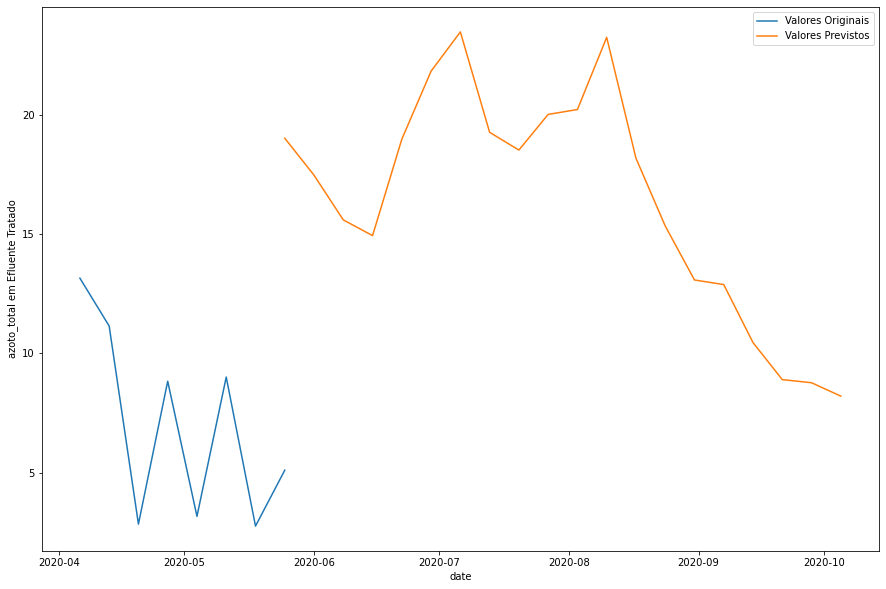

127.0.0.1 - - [27/Jun/2021 19:33:02] "POST /prediction_next_days HTTP/1.1" 200 -
127.0.0.1 - - [27/Jun/2021 19:33:02] "GET /prediction_next_days_values HTTP/1.1" 200 -
127.0.0.1 - - [27/Jun/2021 19:33:02] "GET /prediction_next_days HTTP/1.1" 200 -
/opt/anaconda3/envs/tese/lib/python3.7/site-packages/ipykernel_launcher.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/envs/tese/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/anaconda3/envs/tese/lib/python3.7/site-packag

Done: <matplotlib.backends.backend_agg.RendererAgg object at 0x7ff3af156cd0>

<Figure size 1080x720 with 1 Axes>

In [ ]:
if __name__ == '__main__':
    app.run()